In [1]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np



def KmeansSeg(image,K):
    
    Z = image.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
    
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    #print(ret)
    #print(label)
    #print(center)
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    
    return res2,ret,label,center


#Image processing tools

def GetImageFromFileCV(filename):
    image = cv2.imread(filename)
    return image    



def ResizeImgCV(image,size):
    image = np.asarray(cv2.resize(image,size))
    return image  

def PltImg(image):
    plt.imshow(image)
    plt.show()

def ColorDistribution2(image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        modified_img = image.reshape(image.shape[0]*image.shape[1], 3)
        hexcolorlist=[]
        for i in range(len(modified_img)):
            #去掉黑色
            if (rgb_to_hex(modified_img[i]) != "#000000"):
                hexcolorlist.append(rgb_to_hex(modified_img[i]))

        unique,counts=np.unique(hexcolorlist,return_counts=True)

        return (unique,counts)

def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        num = int(i)
        #hex_color += ("{:02x}".format(i))
        hex_color += str(hex(num))[-2:].replace("x","0").upper()
    return hex_color


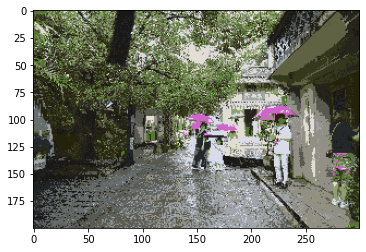

<BarContainer object of 24 artists>

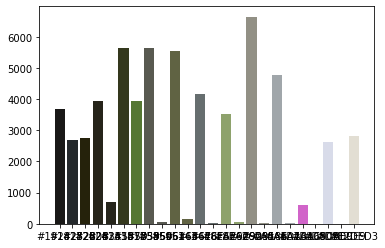

In [3]:
#-------------------------------------------------HSV method ----------------------------------------------

image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0030.JPG")
image = ResizeImgCV(image,(300,200))

image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

#bgr to rgb

(res2,_,_,_)=KmeansSeg(image,15)

res2=cv2.cvtColor(res2,cv2.COLOR_HSV2BGR)

PltImg(res2[:,:,::-1])

#plot graph
res2 = res2
(unique,counts)=ColorDistribution2(res2)
plt.figure(figsize = (6, 4))
plt.bar(unique,counts,color = unique)

--------------- kmeans method-----------------------

聚类结果受颜色在图像中的占比影响
当K取值较小时，聚类结果容易忽略色彩对比鲜明，但占比较少的颜色

--------------- modified kmeans method ------------------

改进算法采用多层聚类方法
1. 首先采用较大K值（例如k=200）进行初步聚类分析，过滤掉图像中的噪声

2. 删掉聚类结果中的重复值，这样就可以消除颜色占比对聚类结果的影响
（这里根据颜色占比设置颜色重复系数scale，根据系数调节颜色占比和重复值的关系）
0<scale<1 
scale = 0 时，相当于删去所有重复值，每种颜色只出现1次
scale = 1 时，相当于保留所有重复值。
3. 根据scale大小调整颜色占比，对结果进行二次聚类

4. Klist控制聚类的迭代次数和k值
例如klist = 200 100 10，表示依次按200,100,10的顺序进行迭代。

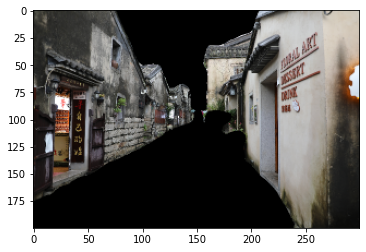

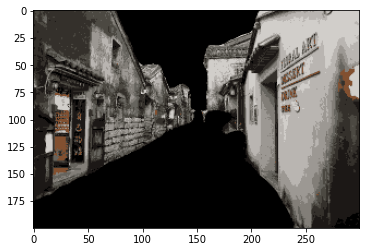

<BarContainer object of 9 artists>

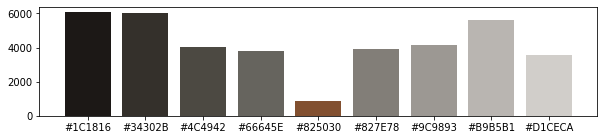

In [70]:
#-------------------------------------------------RGBMethod----------------------------------------------

image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0026masked.png")
image = ResizeImgCV(image,(300,200))


#bgr to rgb
image=image[:,:,::-1]
(res2,_,_,_)=KmeansSeg(image,10)


PltImg(image)
PltImg(res2)

#plot graph
res2 = res2[:,:,::-1]
(unique,counts)=ColorDistribution2(res2)
plt.figure(figsize = (10, 2))
plt.bar(unique,counts,color = unique)

In [83]:
#-------------------------------------------------Multi-Iteration Method----------------------------------------------
def test1(scale):
    image = GetImageFromFileCV("E:\\Downloads\\BaiduNetdiskDownload\\testfile\\2L7A1981.JPG")
    image = ResizeImgCV(image,(300,200))

    Klist=[200,15]
    
    #1st kmeans
    #PltImg(image[:,:,::-1])

    #reshape 
   
    inputImg = image.reshape(-1,3)
   
    for i in Klist:


        #kmeans
        (resultImg,_,labels,centers)=KmeansSeg(inputImg,i)
        #resultImg------>inputImg colormap
        '''
        colormap=[]
        temp=[]
        originImg = image.reshape(-1,3)
        for i in range(len(labels)):

            colormap.append((centers[labels[i]],inputImg[i]))
            
        #colormap=np.unique(colormap)
        '''

        #-------------------process the mod_res-----------------------
        mod_res=resultImg.copy()
        #unique
        (mod_res,indices,imgcounts)=np.unique(mod_res,axis=0,return_counts=True,return_index=True)
        #preseve order
        #mod_res=mod_res[np.argsort(indices)]

        #process the imgcounts, reduce the difference by the scale factor

        mod_counts=Smoothlist(imgcounts,scale)
        #repeat imgcounts
        mod_res=np.repeat(mod_res,mod_counts,axis=0)
        difference=image.shape[0]*image.shape[1]-mod_res.shape[0]*mod_res.shape[1]
        if difference > 0:
            mod_res=np.pad(mod_res,((0,difference),(0,0)),"wrap")

        #------------rebuid image--------------

        

        #PltImg(real_res)

        #print("------------------"+ str(i) +"------------------------")
        print(mod_res.shape)


        #reset the input value
        inputImg=mod_res



    #result=result.reshape(1,-1,3)

    """
    plt.figure(figsize = (6, 4))
    a=np.array([10]*result.shape[0])
    plt.bar(result,a,color = result)
    """

    #PltImg(image)

    #plot graph
    (unique,counts)=ColorDistribution2(mod_res.reshape(1,-1,3))
    plt.figure(figsize = (10, 2))
    plt.bar(unique,counts,color = unique)
    plt.show()


def Smoothlist(inputList,scale):
    workingList = inputList.copy()
    avg=np.average(workingList)
    for i in range(len(workingList)):
        workingList[i]=avg+scale*(workingList[i]-avg)
    return workingList

scale=1.0
(60000, 3)
(60000, 3)


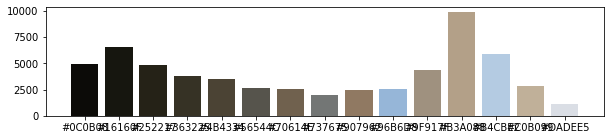

scale=0.8888888888888888
(59909, 3)
(59901, 3)


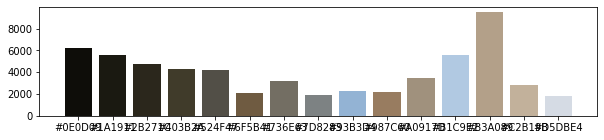

scale=0.7777777777777778
(59908, 3)
(59902, 3)


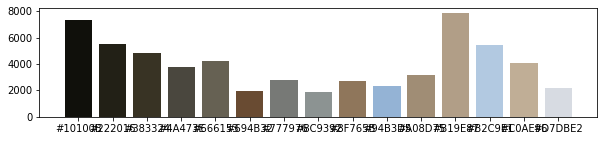

scale=0.6666666666666667
(59927, 3)
(59921, 3)


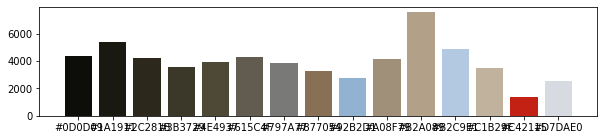

scale=0.5555555555555556
(59910, 3)
(59906, 3)


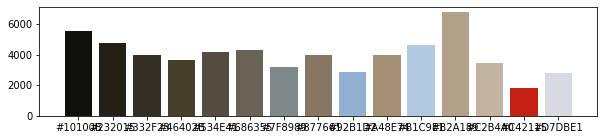

scale=0.4444444444444444
(59916, 3)
(59907, 3)


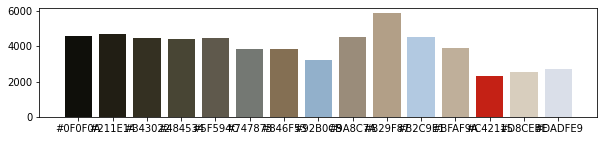

scale=0.33333333333333337
(59933, 3)
(59928, 3)


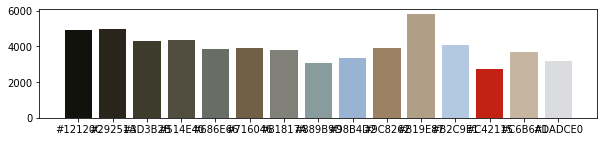

scale=0.2222222222222222
(59908, 3)
(59902, 3)


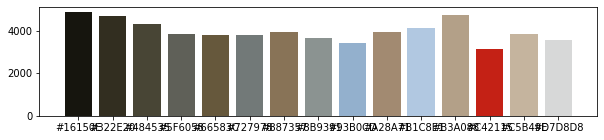

scale=0.11111111111111116
(59908, 3)
(59901, 3)


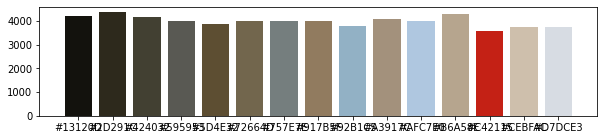

scale=0.0
(60000, 3)
(60000, 3)


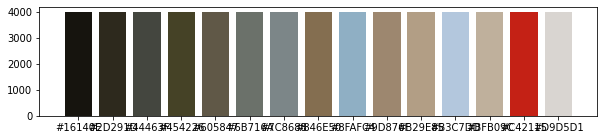

In [84]:
for i in range(10):
    scale =  1 - i/9
    print("scale=" + str(scale))
    test1(scale)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility

image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0030.JPG")
image = ResizeImgCV(image,(30,20))


fig = plt.figure()
plt.figure(figsize = (10, 4))
ax = fig.add_subplot(projection='3d')
image = image.reshape(-1,3)
for element in image:
    ax.scatter(element[0],element[1],element[2])


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# for creating a responsive plot
%matplotlib notebook
  
# importing required libraries
import numpy as np  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
x = np.linspace(0,4*np.pi,1000)
y = np.sin(x) 
z = 15 * np.random.random(1000)
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_scatter = ax.scatter(x, y, z,color='r')
  
# setting title and labels
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

<IPython.core.display.Javascript object>

c:\ProgramData\Anaconda3\envs\gluonPy\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()
